
# Вспомним алгоритм обратного распространения

<img src="./imgs/01.png" width=500>

Нам нужно вычислить градиент: $$\large \frac{\partial f}{\partial x}; \frac{\partial f}{\partial w}; \frac{\partial f}{\partial b} $$

Далее обновляем веса по алгоритму градиентного спуска:
$$
\large
w' = w - \lambda \frac{\partial f}{\partial w}
$$

### В реальном мире мы имеем
1.  $ \large X $ - пространство входных значений размерностью $ |M|$
2.  $ \large Y $ - пространство целевых предсказаний размерностью $ |M|$
3.  $ \large J(x,y,\theta) $ - функция ошибки, которая зависит от параметров $\theta$ модели
4.  $ \large F(\theta) $ - функция преобразования $ X \to Y $ 

Функция ошибки усредняется по всем примерам
$$
\large J(x,y,\theta) = \frac {1} {m} \sum_{i=1}^m { L(\tilde{y_i}, y_i)}
$$

Градиентный спуск, для обновления весов будет выглядеть так:
$$
\large \theta_{t} = \theta_{t-1} - \lambda \frac{\partial J}{\partial \theta} 
$$

**Векторизируя наши данные получаем вход:<br>**
$\large x = [x_1, x_2, x_3, ... , x_M]  \leftarrow $ матрица размером $C \times  M$, $C$ - размер входного вектора<br>
**Выход:<br>**
$\large y = [y_1, y_2, y_3, ... , y_M] \leftarrow $ матрица размером $A \times  M$, $A$ - размер выходного вектора<br>

Что делать, если М достаточно велико? 

# SGD (Stochastic Gradient Descent)

### Классический SGD (онлайн):
$$
\large
\theta_t = \theta_{t-1} - \lambda \frac{\partial L}{\partial \theta}
$$

Сложность - $\large O(M) $. Количество примеров в обучающем датасете может быть >1M или вообще неограничено. <br>
 - В данном случае, для одной итерации нам надо пройти по всему датасету. <br>
 - Можно обучаться "на лету" на вновь поступающих примерах.<br>
 - Нередко шаги могут уводить нас от минимума, в силу того, что мы смотрим только на один пример

### Mini-batch SGD, позволяет использовать ресурсы GPU эффективней
Делим данные на части небольшого размера $B = \{1000,256,64 ...\}$<br>
**Тогда получаем вход:<br>**
$\large x = [\overbrace{x_1, x_2, x_3, ... x_B}^{x^{\{1\}}}, \overbrace{x_{B+1}, x_{B+2}, x_{B+3}, ... x_{2*B}}^{x^{\{2\}}}, ... , x_M]  \leftarrow $ последовательность матриц размером $C \times  B$, $C$ - размер входного вектора<br>
**Выход:<br>**
$\large y = [\overbrace{y_1, y_2, y_3,...,y_B}^{y^{\{1\}}},..., ... , y_M] \leftarrow $ последовательность матриц размером $A \times  B$, $A$ - размер выходного вектора<br>

Функция ошибки усредняется не по всем примерам, а только по батчу размера $B$
$$
\overset{\wedge}{\large J}(x,y,\theta) = \frac {1} {B} \sum_{i=1}^B {\large L(\tilde{y_i}, y_i)}
$$
Получаем следующую функцию отимизации для каждого шага градиентного спуска
$$
\large
\theta_t = \theta_{t-1} - \lambda \frac{\partial \overset{\wedge}{\large J}}{\partial \theta}
$$

** Вопрос: **
Почему при обучении с полным батчем график обучения гладкий, а при использовании мини батча сильно  осциллирует?
<img src="./imgs/minibatch_vs_batch_gd.png" width=800>

Как выглядит градиент в пространстве весов 
1. Для режима online SGD и для обучения с GD
<img src="./imgs/batch_vs_sgd.png" width=800>
2. Для режима mini-batch SGD и для обучения с online SGD
<img src="./imgs/minibatch_vs_batch_sgd.png" width=800>

# Экспоненциальное скользящее среднее

In [22]:
import pandas as pd
from pandas import Series, DataFrame, Panel
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('figure', figsize=(10, 8))
%matplotlib inline

### Предположим, что у нас есть некоторый набор данных о продажах за определенный промежуток времени

In [8]:
data = pd.read_csv('data/time_data.csv', 
                    parse_dates={'Timestamp': ['Date', 'Time']},
                    index_col='Timestamp')
data.head()

,Price,Volume,Exchange Code,Sales Condition,Correction Indicator,Sequence Number,Trade Stop Indicator,Source of Trade,MDS 127 / TRF (Trade Reporting Facility) (*),Exclude Record Flag,Filtered Price
Timestamp,,,,,,,,,,,
2011-11-01 08:04:56.364,104.55,100,P,T,0,196,N,C,NaN,NaN,NaN
2011-11-01 08:53:07.459,104.43,150,T,FT,0,316,N,C,NaN,NaN,NaN
2011-11-01 08:53:09.284,104.43,100,T,FT,0,317,N,C,NaN,NaN,NaN
2011-11-01 08:54:03.921,104.50,100,P,FT,0,318,N,C,NaN,NaN,NaN
2011-11-01 08:58:06.162,104.46,1000,Z,T,0,322,N,C,NaN,NaN,NaN


Хотим изучить как менялась цена на товар за месяц.

In [227]:
ticks = data.loc['2011-11-03':'2011-11-04', ['Price', 'Volume']]
ticks.head()

,Price,Volume
Timestamp,,
2011-11-03 09:21:55.687,103.77,100
2011-11-03 09:30:00.323,103.80,20
2011-11-03 09:30:00.589,103.80,133
2011-11-03 09:30:00.589,103.80,122
2011-11-03 09:30:00.589,103.80,358


(103.5, 104.5)

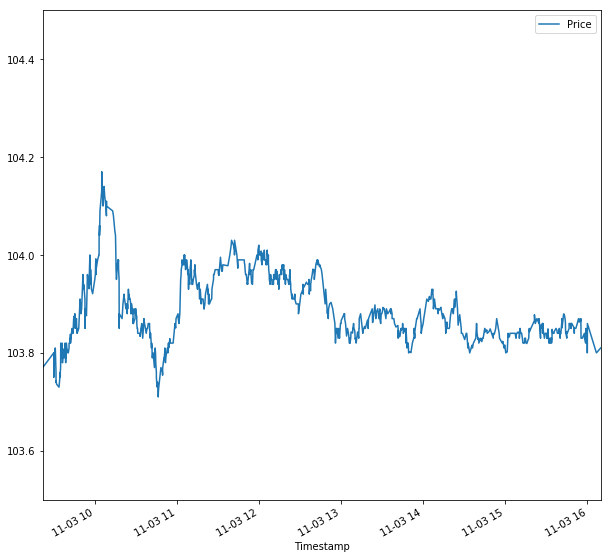

In [228]:
ticks.loc[:, ['Price']].plot(figsize=(10,10))
plt.ylim(103.5, 104.5)

Данные получаются слишком шумные, большая дисперсия, хотим получить картинку по средней цене, что посволит нам сгладит флуктуации. <br> 
Как посчитать среднее для какого либо временного ряда если мы не знаем точное количество точек?
<br>
Используем экспоненциальное скользящее среднее, для подсчета среднего значения временнной последовательности на шаге $t$:

$$
\large V_t = \beta*V_{t-1} + (1-\beta)*\theta_t
$$

$\beta$ - сглаживающий момент 

$\theta_t$ - значение на текущем шаге

Напишем небольшую функцию, которая реализует усреднение

In [229]:
def exp_moving_avg(table, beta, column):
    V = 0. # среднее значение в точке
    one_minus_beta = 1 - beta
    ticks[column] = 0.
    for t, row in ticks.T.iteritems():
        V = beta * V  + one_minus_beta * row['Price']
        table.set_value(t, column, V)

In [230]:
exp_moving_avg(ticks, 0.9, 'B_0.9')
exp_moving_avg(ticks, 0.99, 'B_0.99')
exp_moving_avg(ticks, 0.5, 'B_0.5')

(103.6, 104.2)

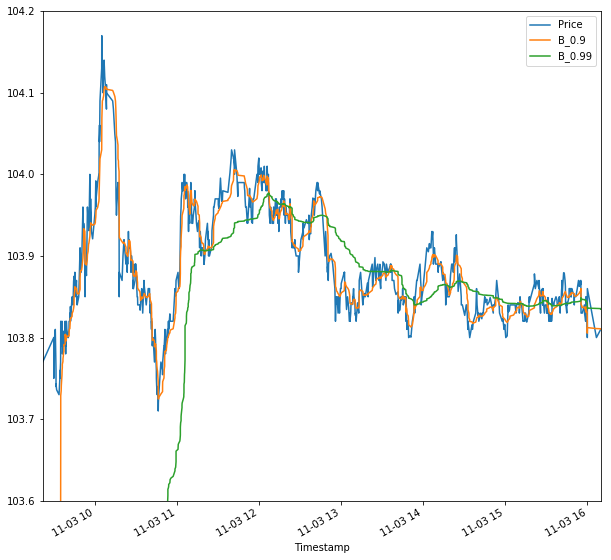

In [231]:
ticks.loc[:,  ['Price', 'B_0.9', 'B_0.99']].plot(figsize=(10,10))
plt.ylim(103.6, 104.2)

(103.6, 104.2)

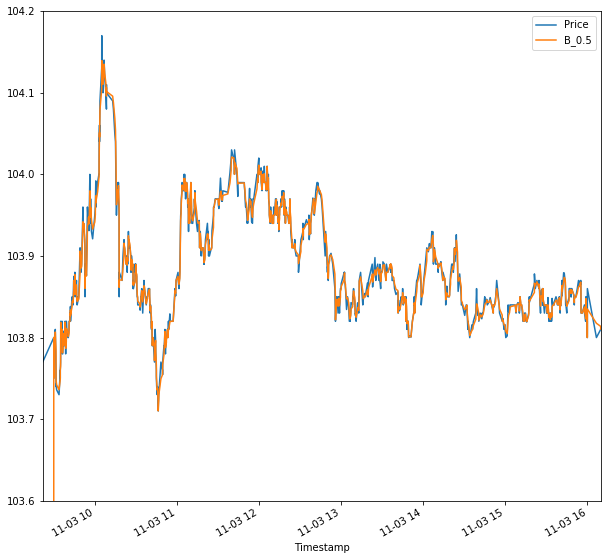

In [232]:
ticks.loc[:,  ['Price', 'B_0.5']].plot(figsize=(10,10))
plt.ylim(103.6, 104.2)

Как бороться с провалом в начальных значениях? 

Коррекция биаса на начальных точках. 
$$
\large V_t =  \beta * V_{t-1} + {(1-\beta)*\theta_t } \\
\large \hat{V_t} = \frac {V_t}{1-\beta^t} 
$$

Перепишем нашу функцию

In [234]:

def exp_moving_avg_no_bias(table, beta, column):
    V = 0. # среднее значение в точке
    one_minus_beta = 1. - beta
    ticks[column] = 0.
    step = 1.
    for t, row in ticks.T.iteritems():
        denom = (1. - (beta ** step)) if step == 1 else 1       
        V =  beta * V  + one_minus_beta * row['Price'] / denom 
        table.set_value(t, column, V  )
        step += 1.


In [241]:
exp_moving_avg_no_bias(ticks, 0.9, 'BB_0.9')
exp_moving_avg_no_bias(ticks, 0.99, 'BB_0.99')

(103.6, 104.2)

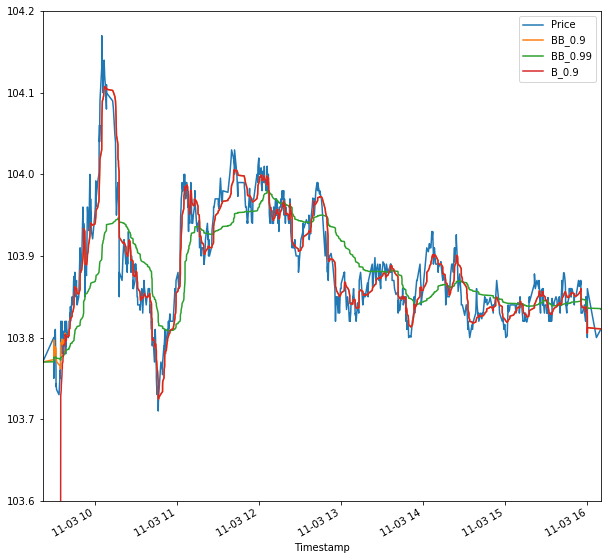

In [242]:
ticks.loc[:,  ['Price', 'BB_0.9','BB_0.99' ,'B_0.9']].plot(figsize=(10,10))
plt.ylim(103.6, 104.2)

## Экспоненциальное скользящее среднее активно используется в продвинутых методах оптимизации нейро сетей

# Продвинутые методы оптимизации
## Проблемы
- SGD - медленно сходится
- SGD - может застрять в локальном минимуме
- SGD - не решает проблему редких признаков  

## SGD + Momentum
### Ускоряет схождение

$$
\Large
\begin{align}
g_t &= \nabla_{\theta} \overset{\wedge}{\large J}\left(x,y,\theta \right) - градиент \\
m_t &= \beta m_{t-1} - (1- \beta) g_t, \ где \  \beta - параметр\ обучения \\
m_t &= \alpha m_{t-1} - \lambda g_t, \ альтернативная \ форма \ записи \\
\theta_t &= \theta_{t-1} + m_t
\end{align}
$$
<img src="./imgs/4.gif" width=500>



## RMSProp (Root Mean Square Propagation)
### Решаем проблемму редких признаков, ускоряя схождение.
$$
\Large
\begin{align}
v_t &- скользящее\ среднее\ по \ g^2 \\
v_t &= \beta * v_{t-1} +  (1-\beta)* g_{t}^2  \\
\theta &= \theta - \lambda \frac{1}{\sqrt{v_t + \epsilon}} g_t
\end{align}
$$
### Долго накапливает начальные значения 

## Adam (Adaptive Moment Estimation) 

Adam = SGD + Momentum + RMSProp

$$
\large
\begin{align}
m_t &= \alpha \ m_{t-1} + (1 - \alpha)\ g - момент \\ 
v_t &= \beta \ v_{t-1} +  (1-\beta)\ g_{t}^2  - скользящее\ среднее \\
\\
& исправляем \ недостаток \ RMSProp \ корректируем\ биас\ на\ начальных \ точках \\
\hat{m_t} &= \frac{m_t}{1 - \alpha^t} \\
\hat{v_t} &= \frac{v_t}{1 - \beta^t} \\
\theta_t &= \theta_{t-1} -  \frac{\lambda}{\sqrt{\hat{v_t} + \epsilon}}\hat{m_t} \\
\ выразим\ step\_size \ через \ \alpha \ и \ \beta \\
\ step\_size =  \lambda \frac {({1 - \beta^t})^2}{{1 - \alpha^t}} \\ 
\theta_t &= \theta_{t-1} -  \frac{step\_size}{\sqrt{v_t + \epsilon}}\times m_t 
\end{align}
$$



<img src="./imgs/6.gif" width=500>

### Оптимизаторы в pytorch 

```python
from torch.optim import Adam, SGD, RMSprop
```

[Ссылка на документацию](https://pytorch.org/docs/stable/optim.html)

# Многослойность требует нелинейной активации.
## Почему?
- Рассмотрим однослойный персептрон
$\large y = \sum_i{x_i^L w_i^L} $
- добавим к нему еще слой, тогда для i-того нейрона  
$\large x_i^L = \sum_j{x_j^{L-1}w_j^{L-1}} $
$\large \to $ 
$\large y = \sum_i{\left(\sum_j{x_j^{L-1}w_j^{L-1}}\right)_i^L w_i^L}$
- Видно, что получившаяся система будет является линейной системой
- Нужно вводить нелинейность - нелинейную функцию активации
- Условие - функция должна быть дифференцируема 


# Функции активации


## 1. Сигмоид 
$$\large \sigma (x) = \frac{1}{1+e^{-x}} $$
<img src="./imgs/29.png" >
### Производная
$$\large \frac{d\sigma (x)}{d(x)} = \sigma (x)\cdot (1-\sigma(x)) < 1 $$

<img src="./imgs/30.png" >

```python
# pytorch class
class torch.nn.Sigmoid
```

## Проблемы сигмоида
### 1. Рассмотрим сеть, состоящую из слоев с одним нейроном
$$\large y = \sigma_3{(\sigma_2{(\sigma_1{(xw_1)}w_2)}w_3)} $$
- Чему будет равна производная?
$$\large \frac{d y}{d x} = \frac{\partial{y}}{\partial{\sigma_3}}\frac{\partial{\sigma_3}}{\partial{\sigma_2}}\frac{\partial{\sigma_2}}{\partial{\sigma_1}}\frac{\partial{\sigma_1}}{\partial{x}} << 1 $$

- Видно,что при малых значениях производных на градиент на первых слоях становится незначительным (может затухать экспоненциально) и становится меньше точности float. Сеть перестанет обучаться.

### 2. Что будет если у нас только положительный вход слоя $\large l$ ?
$$ \large 
f^l(x) = \sigma{\left(\sum_i{h^l_i w^l_i + b^l}\right)} \\
\large h_i^l = \sigma{\left(\sum_i{x^{l-1}_i w^{l-1}_i + b^{l-1}}\right)} > 0
$$
- Нейрон для $\large f^l(x) $ войдет в нелинейную область насыщения функции и градиент по нему будет равен нулю, из-за проблемы точности.


## Центрированная функция 
$$ \large tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$$
<img src='./imgs/tanh.png'>
- имеет ту-же проблему с затуханием градиента

```python
# pytorch class
class torch.nn.Tanh
```

## Функция активации, которая:
1. Нелинейна
2. Не затухает градиент

 ## 2. ReLU (Rectifier linear unit)

$$\large f(x)= max(0, x) $$
<img src="./imgs/31.png" >

## производная 
$$\large 
\frac{df}{dx} = 0 \ if\  x <= 0 \\
\large \frac{df}{dx} = 1 \ if\  x > 0
$$

```python
#python class
class torch.nn.ReLU(inplace=False)
# inplace - нужно ли сохранять выход элемента в графе
```

Пример графика обучения из статьи [ImageNet Classification with Deep Convolutional Neural Networks](http://www.cs.toronto.edu/~fritz/absps/imagenet.pdf)
<img src='./imgs/relu_train.png'>
Процесс тренировки конволюционной сети 
- Пунктир - сеть с активацией тангес
- Сплошная линия - активация ReLU


## Проблема ReLU 
- Мертвые нейроны если  $\large \sum_i{x_i w_i + b} < 0 $

### Как решить?
$$
\large ReLU(y) = max(0, y) \\
\large Leaky ReLU = max(\alpha y, y), \alpha < 1. - можно \ использовать \ коэффициент \ обучения
$$
<img src='./imgs/prelu.png'>

### Нужно подбирать параметр $\large \alpha $ 
- можно использовать экспоненту => ELU
- $\large y =  x \ if \ x > 0 \ else\ \alpha (e^x - 1) $
- с экспонентой считать тяжелей
<img src='./imgs/elu.png'>

## Самый правильный способ
- Обобщает лучше чем ReLU или ELU
- Линейны режим
- Нет насыщения
- Нет затухания
$$\large max(w_1^Tx+b_1, w_2^Tx+b_2) $$

### Приводит к удвоению параметров сети :(

<hr>

# Переобучение
<img src='./imgs/overfitting.png'>
- Возникает когда количество парметров сети перекрывает вариативность данных, как результат сеть запоминает примеры в обучающей выборке
- Обобщающая способность модели падает, что можно контролировать на валидационном множестве
- Как правило, переобучение, сопровождается ростом весов сети
### Регуляризация
1. Добавляем дополнительный член в функцию ошибки, который ограничмвает рост весов ($ L^2 $ регуляризация)
$$ \large
    L_{reg} \left(X, \vec{y}, \vec{w}\right) =\left\| \vec{y} - X \vec{w} \right\|_2^2  + \frac{\lambda}{2} \left\| \vec{w} \right\|_2^2
$$
2. Делаем аугментацию, рассмотрим далее.
3. Уменьшаем количество параметров модели. Маленькая модель - хуже качество

# Ансамбль моделей (bagging)

Допустим, мы построили набор из $\large k $ регрессионных моделей. Предположим, что каждая модель делает ошибку $\large \epsilon_i$, c дисперсией $\large \mathop{\mathbb{E}}\left[\epsilon_i^2\right] = v$ и ковариацией $\large \mathop{\mathbb{E}}\left[\epsilon_i \epsilon_j\right] = c$. Тогда ошибка всего ансабля моделей - $\large \frac{1}{k}\sum_i{\epsilon_i} $. Тогда ожидание среднеквадратичной ошибки будет равно:
$$
\large \mathop{\mathbb{E}}\left[\left(\frac{1}{k}\sum_i{\epsilon_i}\right)^2\right] = \frac{1}{k^2} \mathop{\mathbb{E}}\left[\sum_i{\left(\epsilon_i^2 + \sum_{{j}\neq{i}}{\epsilon_i}{\epsilon_j}\right)}\right] = \frac{1}{k}v+\frac{k-1}{k}c
$$

- Если у нас модели скорелированы $\large c=v $, то среднеквадратичная ошибка всего ансамбля уменьшается до v
- Если у нас модели не скорелированы $\large c=0 $, то среднеквадратичная ошибка уменьшается до $\large \frac{1}{k}v$

# Dropout
### Идея - отключаем часть нейронов слоя сети по распределению бернули с вероятностью $\large p $, см. схему
- Сразу возникает ассоциация с ансамблем моделей, в котором каждая модель представлена подграфом сети
### Основные отличия от ансамбля:
1. Веса моделей общие
2. Каждая модель обучается не до полной сходимости
3. Количество моделей растет экспоненциально в процессе обучения.

<img src="./imgs/33.png" >


### Описание модели
Обычная сеть прямого распространения со слоем $\large l+1 $ и нейроном $\large i $
$$\large 𝑧_𝑖^{(𝑙+1)} =\mathbf{𝑤}_𝑖^{(𝑙+1)}\mathbf{𝑦}^𝑙+𝑏_𝑖^{(𝑙+1)} $$ 
$$\large y_i^{(l+1)} = f(z_i^{(𝑙+1)}) $$ 

Для сети с dropout прямой проход при обучении будет выглядеть так:

$$
\large
\begin{aligned}
p - вероятность\ семплирования \\
r_j^{(l)} ~ Bernoulli(p) \\
\tilde{y} = \mathbf{r}^l \mathbf{y}^l \\
𝑧_𝑖^{(𝑙+1)} =\mathbf{𝑤}_𝑖^{(𝑙+1)}\mathbf{\tilde{𝑦}}^𝑙+𝑏_𝑖^{(𝑙+1)} \\
y_i^{(l+1)} = f(z_i^{(𝑙+1)})
\end{aligned}
$$

Для предсказания проблема, - мы не знаем $\large k$ (количество моделей)
$$
\large
\begin{aligned}
используем \ вероятность\ семплирования - p \\
\tilde{w} = p \mathbf{w}_i^{l+1} \\
𝑧_𝑖^{(𝑙+1)} =\mathbf{\tilde{𝑤}}_𝑖^{(𝑙+1)}\mathbf{𝑦}^𝑙+𝑏_𝑖^{(𝑙+1)} \\
y_i^{(l+1)} = f(z_i^{(𝑙+1)})
\end{aligned}
$$
<hr>
<img src="./imgs/35.png" >

[Dropout: A Simple Way to Prevent Neural Networks from Overfitting](http://jmlr.org/papers/volume15/srivastava14a.old/srivastava14a.pdf)

```python
class torch.nn.Dropout(
class torch.nn.Dropout2d(
    p=0.5,         # % фичей, которые нужно занулить
    inplace=False  # делать ли оптимизацию
```
<hr>

# Batch Normalization
Когда мы строим модель мы предполагаем, что у нас есть фиксированная цель $\large Y$, к которой мы подгоняем нашу модель, для получения отображения $\large f: X \to Y$.

1. Цель одного нейрона сети - выучить отображения своего входа на вход следующего слоя. 
2. Мы делаем обновление веса (градиентным спуском), исходя из предположения, что все остальные веса константны, но это не так.
3. Отсюда целевая функция одного нейрона динамически меняется в процессе обучения, потому что меняется статистическое распределение его входа в процессе обучения. Появляется **ковариационный сдвиг**
<img src='./imgs/batch_norm_sample.png'>
4. В результате веса могут иметь сильно отличающие абсолютные значения, что приводит к замедлению схождения сети.

<img src="./imgs/36.png" >

- Для решения этой проблемы нужно, что бы вход нейрона изменялся в заданном диапазоне.
- В прошлой лекции мы решали эту проблемму нормализацией наших данных
<img src='./imgs/normalization_data.png'>
- В нашем случае, данные нейрона - это выход предыдущего слоя.
- Чтобы убрать ковариационный сдвиг нужно нормализовать выход предыдущего слоя.
- Мы не знаем все распределение, но знаем распределение внутри одного батча => попробуем сделать нормализацию по батчу

<img src="./imgs/37.png" width=400>

- Как выглядит формула финальной батч нормализации в слое
$$
\large
\begin{align}
v_t = \beta \ v_{t-1} + (1-\beta)\ \mu_t \\
s_t = \beta \ s_{t-1} + (1-\beta)\ \mu_t \\
\hat{\mathbf{x}} = \frac{\mathbf{x_t} - v_t}{ \sqrt{s_t + \epsilon}} * \gamma + b
\end{align}
$$

- График обучения
<img src="./imgs/38.png" width=400>

### Batch Normalization 
1. Увеличивает количество параметров. 
2. Добавляет новый гиперпараметр - размер батча

[Batch Normalization Ioffe, Szegedy 2015](https://arxiv.org/pdf/1502.03167.pdf)


```python
# Для сетей прямого распространения
class torch.nn.BatchNorm1d(
    num_features,   # Размерность входного слоя, которое следует ожидать на входе
    eps=1e-05,      # Epsilon из знаменателя
    momentum=0.1,   # Момент, с которым идет накопление среднего и дисперсии
    affine=True)    # учить gamma и beta
    
# Для сверточных сетей    
class torch.nn.BatchNorm2d(
    num_features,   # Число фильтров, которое следует ожидать на входе
    eps=1e-05,      # Epsilon из знаменателя
    momentum=0.1,   # Момент, с которым идет накопление среднего и дисперсии
    affine=True)    # учить gamma и beta
```
!!! momentum - в батч нормализации pytorch это $ momentum = 1-\beta$



# Сверточные сети

## Откуда пошли сверточные сети

# 1958 - Hubel and Wiesel

<img src="./imgs/7.jpg" width=500>

<img src="./imgs/9.png" width=500>

- **Simple cells**: дают ответ на ориентацию света 
- **Complex cells**: ответ ориентацию света и движение 
- **Hypercomplex cells**: ответ на движение с конечной точкой
<img src="./imgs/cat_exp.png" width=500>

## 1980 - Neocognitron (Fukushima)

<img src="./imgs/10.jpg" width=400>
<img src="./imgs/11.gif" width=400>


# 1998 LeNet-5 (LeCun et.al.)

<img src="./imgs/12.png" width=700>


# 2012 AlexNet

<img src="./imgs/14.png">
**ImageNet**
- 1000 классов
- 1.2М обучение, 100К тест

**AlexNet**:
<img src="./imgs/13.png">

**AlexNet + ImageNet**:
<img src="./imgs/15.png">


# Взрывной рост GPU
<img src="./imgs/16.jpg">


# Сверточные сети
Переключимся на презентацию

# Сверточный слой

<img src="./imgs/18.jpg">

## Упражнение на свертку
<img src='./imgs/conv_example.png'> 
<img src="./imgs/19.png">



### Свернем кота
### Грузим картинку котэ, 

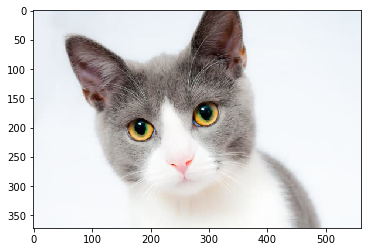

In [3]:
import torch
import torchvision as tv
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
cat_convolve= Image.open('./imgs/cat_convolve.jpg')
plt.imshow(cat_convolve)

### Превращаем кота в тензор

In [4]:
cat_tensor = tv.transforms.ToTensor()(cat_convolve)
print (cat_tensor.size())

torch.Size([3, 372, 560])


### Создаем фильтр ядра и заполняем его -1 & 8

In [5]:
filter_kernel = torch.FloatTensor(3,3,3).fill_(-1)
filter_kernel[:,1,1] = 8
print(filter_kernel.size())

torch.Size([3, 3, 3])


## Моя собственная свертка

In [10]:
import math
from my_conv2d import my_conv2d
# можно использовать torch.nn.functional, для теста, но нужно написать свою имплементацию
# my_conv2d - принимает тензор в формате BxCxHxW т.е. 4d тензор
# B - размер батча в нашем случае 1
# тогда нужно дописать код, и добавить в картинку одну размерность
#  функции 
#  - squeeze() - убирает размерность
#  - unsqueeze() - добавляет размерность
# from torch.nn.functional import conv2d as my_conv2d


### Делаем свертку картинки ядром

torch.Size([370, 558])


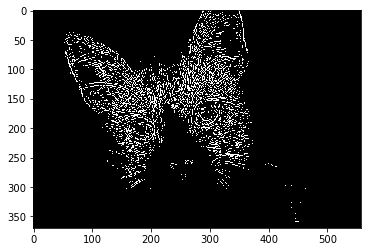

In [11]:
o_image = my_conv2d(cat_tensor, filter_kernel)
o_image[o_image >= 0.5] = 1  # бустим границы
o_image[o_image < 0.5] = 0
print(o_image.size())
plt.imshow(o_image.numpy(), cmap='gray')

### Что будет с картинкой, если мы возьмем ядро  $ \begin{bmatrix}
    1 & 1 \\
    1 & 1
\end{bmatrix}$ и пройдем картинку конволюцией с шагом(stride)=2?


torch.Size([186, 280])


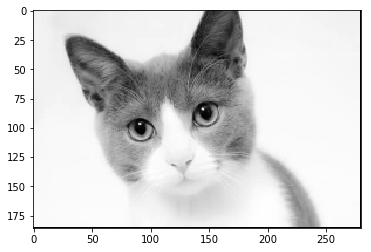

In [24]:
filter_kernelx2 = torch.FloatTensor(3,2,2).fill_(1)
o_image = my_conv2d(cat_tensor, filter_kernelx2, stride=(2,2))
o_image /= 4 # усредняем
print(o_image.size())
plt.imshow(o_image.numpy(), cmap='gray')

# Ядро свертки с гаусовым распределением
--размытие--

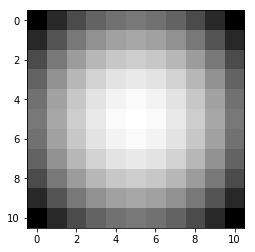

In [42]:
import scipy.ndimage as ndi
import numpy as np
sigma = 10    # параметр распределение
patern_size = 101 # максимальный размер ядра свертки
kernel_size = 10  # реальный размер свертки
x = np.zeros((patern_size, patern_size))
x [patern_size//2,patern_size//2]= 1

# делаем ядро с гаусовым распределением
gause_kernel = ndi.filters.gaussian_filter(x, sigma=sigma)
# вырезаем из центра наш кернел
gause_kernel = gause_kernel[(patern_size//2-(kernel_size//2)):(patern_size//2+(kernel_size//2))+1, \
                (patern_size//2-(kernel_size//2)):(patern_size//2+(kernel_size//2))+1]
# вот он
plt.imshow(gause_kernel, interpolation='none', cmap=plt.get_cmap('gray'))

### делаем свертку

torch.Size([362, 550])


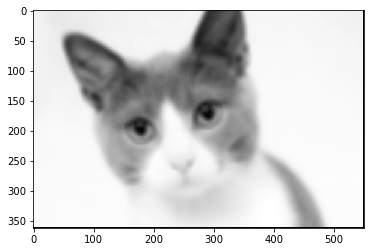

In [41]:
o_image = my_conv2d(cat_tensor, torch.from_numpy(gause_kernel).float().unsqueeze(0))
print(o_image.size())
plt.imshow(o_image.numpy(), cmap='gray')

### *Свертка это трехмерный(двухмерный) тензор и ее можно обучать как слой нейросети*

## Свертка в картинках

Картинка = тензор размера (ширина, высота, число каналов)
<img src="./imgs/20.png" width=300>

1 слой состоит из нескольких фильтров (filter bank)
<img src="./imgs/21.png" width=400>



## Страйд и Паддинг

### Stride
<img src="./imgs/22.gif" width=300>

### Padding
<img src="./imgs/23.gif" width=400>


## Небучаемая 2d свертка в PyTorch
```python
class torch.nn.functional.conv2d(
     x, # входное изображение
     weight, # ядро фильтра
     bias # смещение
    stride=1,     # Шаг свертки
    padding=0,    # Поля - сколько прибавлять по краям     
)
```
## Обучаемая 2d свертка в PyTorch

```python
class torch.nn.Conv2d(
    in_channels,  # Число каналов на входе
    out_channels, # Число каналов на выходе
    kernel_size,  # Размер ядра свертки
    stride=1,     # Шаг свертки
    padding=0,    # Сколько прибавлять по краям
    dilation=1, groups=1, bias=True) # Параметры не интересные в нашем курсе
```

- Вход: $(N, C_{in}, H_{in}, W_{in})$
- Выход: $(N, C_{out}, H_{out}, W_{out})$
- Есть варинаты 1d (для звука, например) и 3d (для объемных томограмм например)


# Математика конволюций

### Одномерная свертка
$$\large s[t] = \int{x[a]w[t-a]da} $$

### Запись через оператор конволюции
$$\large s[t] = (x * w)[t] $$

### В наших задачах мы используем дискретную конволюцию по целым t
$$\large s[t] = \sum_{a=-\infty}^{\infty}{x[a]w[t-a]} $$

### Для двухмерной свертки
$$\large S[i,j] = (I * K)[i,j] = \sum_m{ \sum_n{ I[m, n]K[i-m, j-n]} } $$
- Сверка линейная операция
- Свертка коммутативна
$$\large S[i,j] = (I * K)[i,j] = \sum_m{ \sum_n{ I[i-m, j-n]K[m, n]} } $$
- Свертка ассоциативна
$$\large M * (I * K) = (M * I) * K $$


### Конволюционная сеть - последовательность сверточных слоев и нелинейных функций активации
- Для извлечения более информативных признаков из картинок нужно увеличивать количество карт признаков
- Это приводит к увеличению объема занимаемой памяти.
- Можно уменьшать размер одной карты признаков, т.е. делать понижающую свертку downsampling, в тоже время увеличивая количество карт признаков

# Pooling
* Average polling - был в примере с котэ проходим по изображению сверткой  $ \begin{bmatrix}
    1 & 1 \\
    1 & 1
\end{bmatrix}$ с шагом > 1 и результ усредняем

* Max Pooling - выбирается максимальное значение

<img src="./imgs/26.jpg" width=400>
<img src="./imgs/27.jpg" width=400>


```python
# class pytorch
# pooling среднего
class torch.nn.AvgPool1d(
# pooling максимального значения
class torch.nn.MaxPool2d(kernel_size,  # размер ядра
                         stride=None,  # шаг
                         padding=0,    # поля
```

### Average & Max Pooling не диффирецируемы и не имеют обучаемых параметров
- Можно использовать вместо свертку с обучаемыми параметрами



# Augmentation
Если данных мало, то велика вероятность, что сеть переобучится. Наряду с такими подходами как dropout, batch normalizatio можно увеличить разнообразие данных путем внесения в них искуственных изменений, моделируя возможное распределение в данных.
1. Шум $\large x = x + Noise(~N(0, 1)) $
2. Повороты входного изображения
3. Сдвиг изображения
4. Crop - обрезание изображения
5. Увеличение изображения
6. Зеркальное отражение
7. Цветовой микс
8. Насыщение цветового баланса
9. Изменение яркости
<img src="./imgs/32.png" >
<img src="./imgs/41.png" >

```python
# определены основные трансформации
import torchvision.transforms as transform 
```

# Loss функции

```python
class torch.nn.MSELoss
class torch.nn.CrossEntropyLoss # Комбинация Cross Entropy и Softmax в одном слое
class torch.nn.NLLLoss # Оптимизация правдоподобия, на вход ожидает логарифмы вероятностей (выход LogSoftmax)
```


# Put it all together
Решаем MNIST конволюциями

In [41]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

In [18]:
# Загружаем MNIST
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original', data_home='./')
X = mnist['data']
# переходим к формату тензоров pytorch
X = X.reshape((-1, 1, 28, 28))
X = X.astype('float')
print(X.shape)

(70000, 1, 28, 28)


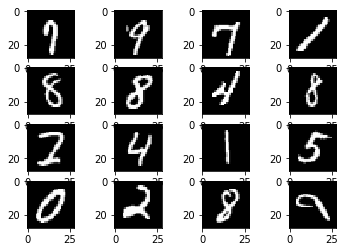

In [19]:
n=4
for i in range(n*n):
    plt.subplot(n,n,i+1)
    I = X[np.random.randint(0, X.shape[0]),0]
    plt.imshow(I, cmap='gray')

In [20]:
from sklearn.preprocessing import OneHotEncoder

Y = mnist['target'].astype('int')
print('original', Y)


original [0 0 0 ..., 9 9 9]


## Определение нашей модели
Параметры инициализации
- Без параметров - конволюции и активации
- dropout = True - c dropout
- batchnorm ^ True - включаем  batch normalization

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from torch.autograd import Variable

class Net(nn.Module):

    # Слои, в которых нет параметров для обучения можно не создавать, а брать из переменной F
    def __init__(self, batchnorm=False, batchnorm=False):
        super(Net, self).__init__()
        #
        # спецальный модуль, который позволяет 
        # объединять компоненты
        self.net = nn.Sequential(nn.BatchNorm2d(1))
        
        # вход 28x28, выход 24x24 (28-5)/1 + 1 = 24
        self.net.add_module('conv_1', nn.Conv2d(1, 8, kernel_size=5, stride=1))
        
        # добавляем дропаут и бн
        if batchnorm: self.net.add_module('bn_1', nn.BatchNorm2d(8))
        if dropout: self.net.add_module('do_1', nn.Dropout(0.5))
            
        self.net.add_module('relu_1', nn.ReLU())
        
        # конволюция, которая уменьшает размер картинки в два раза 
        # (24+2-3)/2+1 = 13, либо используем nn.MaxPool2d
        self.net.add_module('pool_1', nn.Conv2d(8, 8, kernel_size=2, stride=2)) 
        
        # далее conv->relu->pool
        self.net.add_module('conv_2', nn.Conv2d(8, 16, 5)) # in 12x12, out 8x8
        
        # добавляем дропаут и бн
        if batchnorm: self.net.add_module('bn_2', nn.BatchNorm2d(16))
        if dropout: self.net.add_module('do_2', nn.Dropout(0.5))
            
        self.net.add_module('relu_2', nn.ReLU() )
        self.net.add_module('pool_2', nn.MaxPool2d(kernel_size=2, stride=2))                  
        self.fc1 = nn.Linear(16 * 4 * 4, 10)
        # relu

    def forward(self, x):
        x = self.net(x)
        # Вытягиваем многомерный тензор катринки в одну линию
        x = x.view(-1, 16 * 4 * 4)
        x = self.fc1(x)
        x = F.relu(x)
        return x
   
net = Net()
print(net)

Net(
  (net): Sequential(
    (0): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv_1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
    (relu_1): ReLU()
    (pool_1): Conv2d(8, 8, kernel_size=(2, 2), stride=(2, 2))
    (conv_2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
    (relu_2): ReLU()
    (pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=256, out_features=10, bias=True)
)


## Функция обучения модели

In [2]:
def fit_net(c_epoch, net):
    loss_fn = torch.nn.CrossEntropyLoss()

    learning_rate = 1e-4
    batch_size = 30
    # Оптимизатор
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    loss_curve = []

    for iter in range(c_epoch):
        Xperm = np.random.permutation(X.shape[0])
        loss_acc = 0
        nbatches = X.shape[0]//batch_size
        for b in range(nbatches):
            batch_idxs = Xperm[b*batch_size:(b+1)*batch_size]
            x = Variable(torch.Tensor(X[batch_idxs]))
            y = Variable(torch.from_numpy(Y[batch_idxs]).long())
            y_pred = net(x)
            loss = loss_fn(y_pred, y)
            loss_acc += loss.data[0]
            optimizer.zero_grad()        
            loss.backward()
            optimizer.step()    
        avg_epoch_loss = loss_acc / (nbatches)
        print('Do epoch %s with loss %s' % (iter, avg_epoch_loss ))
        loss_curve.append(avg_epoch_loss)
    
    return loss_curve
#plt.plot(loss_curve)

### Обучаем модель без параметров

In [3]:
loss_curve_simple = fit_net(10, net)

NameError: name 'np' is not defined

## Обучаем модель с dropout

In [58]:
net_do = Net(dropout=True)
print ( net_do )

Net (
  (net): Sequential (
    (0): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True)
    (conv_1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
    (do_1): Dropout (p = 0.5)
    (relu_1): ReLU ()
    (pool_1): Conv2d(8, 8, kernel_size=(2, 2), stride=(2, 2))
    (conv_2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
    (do_2): Dropout (p = 0.5)
    (relu_2): ReLU ()
    (pool_2): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  )
  (fc1): Linear (256 -> 10)
)


In [63]:
loss_curve_dropout = fit_net(10, net_do)

Do epoch 0 with loss 1.224458001978756
Do epoch 1 with loss 0.9186339127470687
Do epoch 2 with loss 0.8591561818513755
Do epoch 3 with loss 0.6419267333066749
Do epoch 4 with loss 0.6049533740030917
Do epoch 5 with loss 0.5832699653203529
Do epoch 6 with loss 0.5678123317417787
Do epoch 7 with loss 0.5597348024073048
Do epoch 8 with loss 0.5516912672114612
Do epoch 9 with loss 0.5466079441419345


## Обучаем модель с batch normalization

In [66]:
net_bn = Net(batchnorm=True)
print ( net_bn )
loss_curve_bn = fit_net(10, net_bn)

Net (
  (net): Sequential (
    (0): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True)
    (conv_1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
    (bn_1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True)
    (relu_1): ReLU ()
    (pool_1): Conv2d(8, 8, kernel_size=(2, 2), stride=(2, 2))
    (conv_2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
    (bn_2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
    (relu_2): ReLU ()
    (pool_2): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  )
  (fc1): Linear (256 -> 10)
)
Do epoch 0 with loss 0.7741872026424167
Do epoch 1 with loss 0.18013559527171435
Do epoch 2 with loss 0.11405660841730574
Do epoch 3 with loss 0.08779337604227166
Do epoch 4 with loss 0.0734162602311761
Do epoch 5 with loss 0.06460864437034253
Do epoch 6 with loss 0.058131778781642385
Do epoch 7 with loss 0.052859467764529156
Do epoch 8 with loss 0.0491664662810088
Do epoch 9 with loss 0.04569542729875621


 ## Кривые обучения

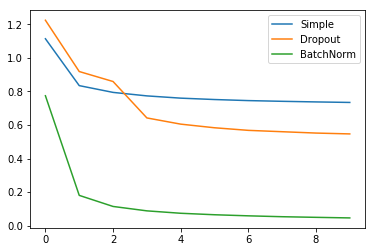

In [94]:
ax = plt.subplot(1,1,1)
ax.plot(loss_curve_simple,label="Simple")
ax.plot(loss_curve_dropout,label="Dropout")
ax.plot(loss_curve_bn, label='BatchNorm' )
ax.legend()

# Home Work 
1. Реализовать свертку и выполнить задание с котом. Нужно прислать IPython notebook с выполенным заданием.
2. TODO - Конкурс на kagle, либо реализация своих модулей для обучения сети


## CIFAR-10
<img src="./imgs/40.png" width=600 >

https://www.cs.toronto.edu/~kriz/cifar.html
- 32х32 цветные картинки
- 10 не пересекающихся классов
- 50к train + 10k test (сбалансированно по классам)


# Почитать

- https://m2dsupsdlclass.github.io/lectures-labs/slides/03_conv_nets/index.html
- http://pytorch.org/tutorials/index.html

<img src="./imgs/50.jpg" width=600 >
